In [1]:
# !conda install nbformat

In [2]:
# Import Libraries
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.pipeline import Pipeline
from joblib import dump
import pickle
import pandas as pd
import numpy as np 
import plotly.graph_objects as go
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error

In [3]:
# Import Training Data
past_data = pd.read_csv('/Users/daviddiaz/Desktop/Main/crypto-lstm-predictor/model_training/train_data.csv')
# Import Testing Data
test_data = pd.read_csv('/Users/daviddiaz/Desktop/Main/crypto-lstm-predictor/model_training/test_data.csv')

In [4]:
# Create a candlestick plot using Plotly
fig = go.Figure(data=[go.Candlestick(x=past_data['Date'],
                                     open=past_data['Open'],
                                     high=past_data['High'],
                                     low=past_data['Low'], 
                                     close=past_data['Close'])])

fig.update_layout(title='Ethereum Price Over Time',
                  xaxis_title='Date',
                  yaxis_title='Price (USD)')

# Show the plot
fig.show()

### Statistical Analysis

In [5]:
# Calculate ACF and PACF
acf_values = acf(past_data['Close'], nlags=40)  # You can adjust the number of lags
pacf_values = pacf(past_data['Close'], nlags=40)  # You can adjust the number of lags

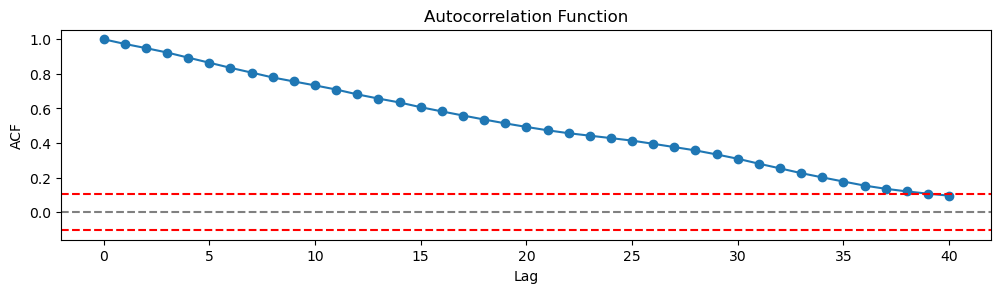

In [6]:
# Plot ACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(acf_values, marker='o')
plt.axhline(y=0, color='gray', linestyle='--')
plt.axhline(y=-1.96 / np.sqrt(len(past_data)), color='red', linestyle='--')  # 95% confidence interval
plt.axhline(y=1.96 / np.sqrt(len(past_data)), color='red', linestyle='--')   # 95% confidence interval
plt.title('Autocorrelation Function')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

#### Analysis suggest that there is significant autocorrelation at these lags, therefore, the past values are strongly influencing future ones

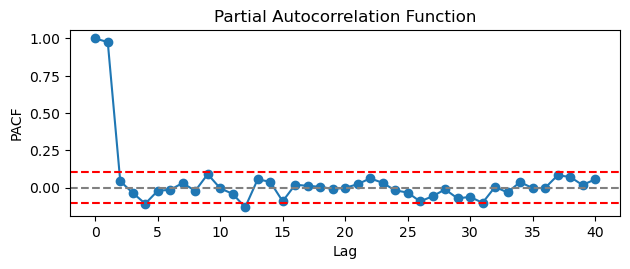

In [7]:
# Plot PACF
plt.subplot(212)
plt.plot(pacf_values, marker='o')
plt.axhline(y=0, color='gray', linestyle='--')
plt.axhline(y=-1.96 / np.sqrt(len(past_data)), color='red', linestyle='--')  # 95% confidence interval
plt.axhline(y=1.96 / np.sqrt(len(past_data)), color='red', linestyle='--')   # 95% confidence interval
plt.title('Partial Autocorrelation Function')
plt.xlabel('Lag')
plt.ylabel('PACF')

plt.tight_layout()
plt.show()

#### Analysis of the PACF test provide information that the there is no significant direct relationship betwen the series and its lags.

In [8]:
# Perform the ADF test
adf_result = sm.tsa.adfuller(past_data['Close'])

# Print the results
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values:\n{adf_result[4]}")

ADF Statistic: -1.860783481308056
p-value: 0.3507285932813605
Critical Values:
{'1%': -3.448748905151901, '5%': -2.8696473721448728, '10%': -2.5710891239349585}


#### With the high p-value and ADF statistic, it can be condcluded that the data is not stationary. 

## Making it Stationary

In [9]:
# Perform first differencing
data_diff = past_data['Close'].diff().dropna()

# Check ADF test on differenced data
diff_adf_result = sm.tsa.adfuller(data_diff)
print(f"Differenced ADF Statistic: {diff_adf_result[0]}")
print(f"Differenced p-value: {diff_adf_result[1]}")


Differenced ADF Statistic: -19.147214321732243
Differenced p-value: 0.0


#### Data is stationary

In [10]:
# Prepare sequences
def create_sequences(data, look_back=5):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

In [11]:
look_back = 5
X, y = create_sequences(data_diff, look_back=look_back)

In [12]:
# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [13]:
# Scale features
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Build LSTM model
model = Sequential([
    LSTM(50, input_shape=(look_back, 1)),
    Dense(1)
])

/Users/daviddiaz/anaconda3/envs/test_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [14]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
history = model.fit(X_train_scaled, y_train_scaled, epochs=120, batch_size=32, validation_split=0.2)

Epoch 1/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1288 - val_loss: 0.0711
Epoch 2/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0673 - val_loss: 0.0238
Epoch 3/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0170 - val_loss: 0.0090
Epoch 4/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0122 - val_loss: 0.0117
Epoch 5/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133 - val_loss: 0.0089
Epoch 6/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094 - val_loss: 0.0089
Epoch 7/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0122 - val_loss: 0.0088
Epoch 8/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0136 - val_loss: 0.0088
Epoch 9/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0103 - val_loss: 0.0087
Epoch 10/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - val_loss: 0.0087
Epoch 11/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0127 - val_loss: 0.0087
Epoch 12/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - val_loss: 0.0088


In [16]:
# Print out the Loss of the model
loss = model.evaluate(X_test_scaled, y_test_scaled)
print(f"Test loss: {loss}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9715e-05
Test loss: 8.438456279691309e-05


In [17]:
# Predict on the test set
y_pred = model.predict(X_test_scaled)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Mean Squared Error (MSE): 76.53900007391341
Root Mean Squared Error (RMSE): 8.748657044021867


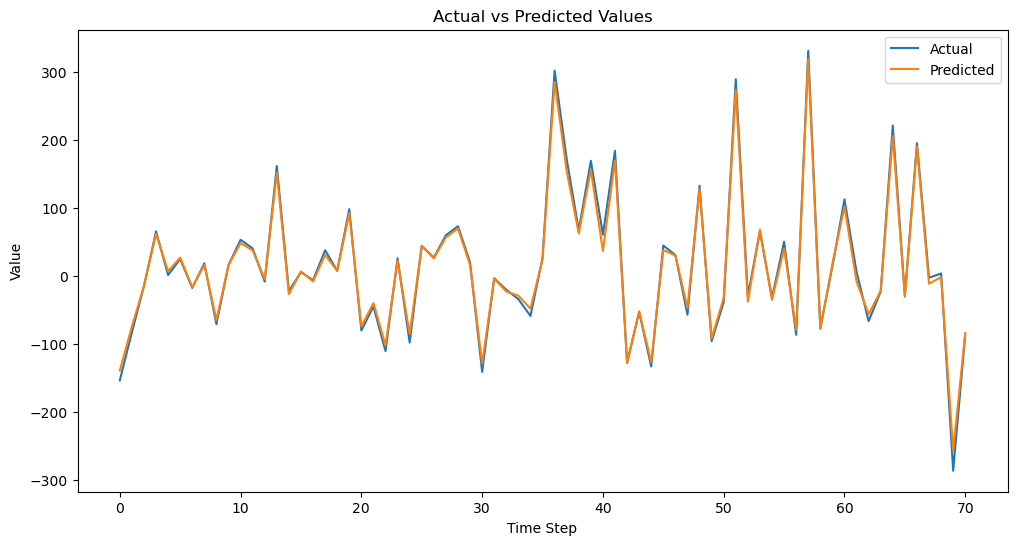

In [18]:
# Convert predictions back to the original scale
y_pred_original_scale = scaler_y.inverse_transform(y_pred)
y_test_original_scale = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))
# Calculate MSE
mse = mean_squared_error(y_test_original_scale, y_pred_original_scale)
print(f"Mean Squared Error (MSE): {mse}")
rmse = root_mean_squared_error(y_test_original_scale, y_pred_original_scale)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_original_scale, label='Actual')
plt.plot(y_pred_original_scale, label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.show()

In [19]:
# Inverse scale the predictions
y_pred_inverse = scaler_y.inverse_transform(y_pred).flatten()

# Create a new DataFrame to store predictions aligned only with y_test
test_indices = past_data.index[look_back + train_size : look_back + train_size + len(y_pred_inverse)]
predictions_df = pd.DataFrame({'Predictions': y_pred_inverse}, index=test_indices)

# Merge predictions into the original DataFrame
past_data = past_data.merge(predictions_df, left_index=True, right_index=True, how='left')


In [20]:
# Get the last actual Close value before the test set starts
last_close = past_data['Close'].iloc[look_back + train_size - 1]

# Reconstruct the predicted Close values from predicted differences
predicted_close = [last_close]
for diff in y_pred_inverse:
    predicted_close.append(predicted_close[-1] + diff)

# Remove the first value (last actual close) as it was used as a starting point
predicted_close = predicted_close[1:]

# Align predictions with the correct indices in the original DataFrame
test_indices = past_data.index[look_back + train_size : look_back + train_size + len(y_pred_inverse)]
predictions_df = pd.DataFrame({'Predicted_Close': predicted_close}, index=test_indices)

# Merge the predicted Close values back into the original DataFrame
past_data = past_data.merge(predictions_df, left_index=True, right_index=True, how='left')


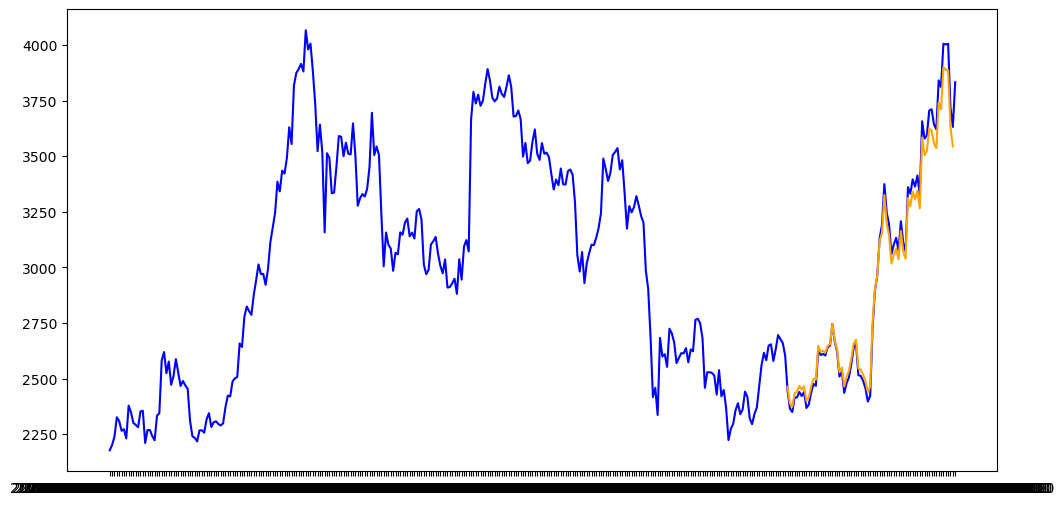

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(past_data['Date'], past_data['Close'], 'blue')
plt.plot(past_data['Date'], past_data['Predicted_Close'], color='orange')
plt.show()

### Run Model On Today's Data

In [22]:
test_diff = test_data['Close'].diff().dropna()
test_data['Close_Diff'] = test_data['Close'].diff().dropna()

In [23]:
test_diff = test_data['Close'].diff().dropna()
test_data['Close_Diff'] = test_data['Close'].diff().dropna()
test_data = test_data.dropna(subset=['Close_Diff']).copy()

X2, y2 = create_sequences(test_diff, look_back=look_back)

In [24]:
# Get the last 5 'Close_Diff' values
last_5_diff = test_data['Close'].diff().dropna()

# Reshape to 5x1
last_5_diff_values = last_5_diff.values.reshape(1, 5)

last_5_diff_values

array([[ -42.80004883,   83.53588867,   35.53979492, -100.71484375,
        -222.04711914]])

In [25]:
# Scale the test data using the same scaler used for training
test_data_scaled = scaler_X.transform(last_5_diff_values)

In [26]:
# Predict the Close_diff using the trained model
predicted_diff_scaled = model.predict(test_data_scaled)

# Inverse transform to get back to the original scale
predicted_diff = scaler_y.inverse_transform(predicted_diff_scaled).flatten() 
print(predicted_diff)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[-196.20355]


In [27]:
# Add predicted differences to the DataFrame
test_data.loc[len(test_data), 'Predicted_Close_Diff'] = pd.Series(predicted_diff.flatten()).values[0]

# Calculate the predicted Close values
test_data['Predicted_Close'] = test_data['Close'] + test_data['Predicted_Close_Diff']

In [28]:
last_5_diff

2    -42.800049
3     83.535889
4     35.539795
5   -100.714844
6   -222.047119
Name: Close, dtype: float64

In [29]:
test_data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,stock_name,Close_Diff,Predicted_Close_Diff,Predicted_Close
1,2024-12-13 00:00:00+00:00,3883.030029,3967.395264,3855.023682,3911.205322,34895127659,0.0,0.0,ETH-USD,28.103760,NaN,NaN
2,2024-12-14 00:00:00+00:00,3910.847900,3943.278076,3826.761963,3868.405273,28756190559,0.0,0.0,ETH-USD,-42.800049,NaN,NaN
3,2024-12-15 00:00:00+00:00,3868.441162,3971.498047,3832.096680,3951.941162,25069616984,0.0,0.0,ETH-USD,83.535889,NaN,NaN
4,2024-12-16 00:00:00+00:00,3951.652832,4106.955566,3882.705322,3987.480957,46536359669,0.0,0.0,ETH-USD,35.539795,NaN,NaN
5,2024-12-17 00:00:00+00:00,3987.333984,4040.337891,3849.286621,3886.766113,35418700472,0.0,0.0,ETH-USD,-100.714844,NaN,NaN
6,2024-12-19 00:00:00+00:00,3625.531982,3673.516602,3557.470215,3664.718994,52247207936,0.0,0.0,ETH-USD,-222.047119,-196.203552,3468.515442


In [30]:
predicted_df = test_data.tail(1)

Mean Squared Error for Close: 38495.83391398564
Mean Squared Error for Close_Diff: 667.8899498321116


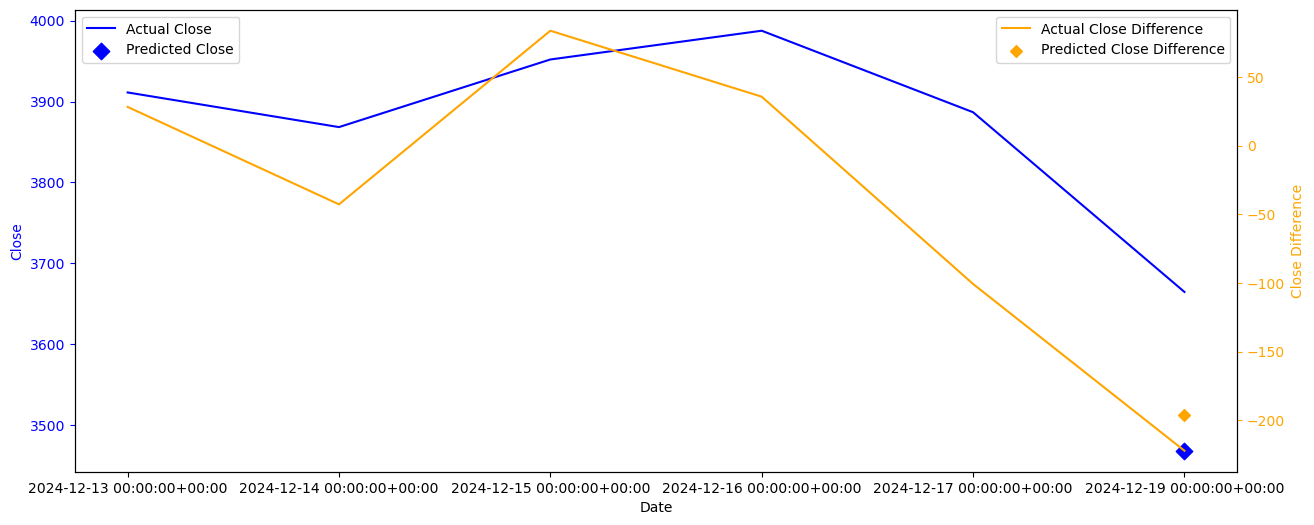

In [31]:
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plotting the Actual Close on the primary y-axis
ax1.plot(test_data['Date'], test_data['Close'], color='blue', label='Actual Close')
ax1.scatter(test_data['Date'], test_data['Predicted_Close'], color='blue', marker='D', label="Predicted Close", s=70)
ax1.set_xlabel('Date')
ax1.set_ylabel('Close', color='blue')
ax1.tick_params('y', colors='blue')
# Calculate Mean Squared Error
mse_close = mean_squared_error(predicted_df['Close'], predicted_df['Predicted_Close'])

# Creating a second y-axis to plot the Predicted Close Difference
ax2 = ax1.twinx()
ax2.plot(test_data['Date'], test_data['Close_Diff'], color='orange', label="Actual Close Difference")
ax2.scatter(test_data['Date'], test_data['Predicted_Close_Diff'], color='orange', marker='D', label="Predicted Close Difference")
ax2.set_ylabel('Close Difference', color='orange')
ax2.tick_params('y', colors='orange')
mse_close_diff = mean_squared_error(predicted_df['Close_Diff'], predicted_df['Predicted_Close_Diff'])

print(f"Mean Squared Error for Close: {mse_close}")
print(f"Mean Squared Error for Close_Diff: {mse_close_diff}")

plt.xticks(rotation=45)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

In [32]:
# Calculate the variance of the actual values
variance_close = np.var(test_data['Close'])
variance_close_diff = np.var(test_data['Close_Diff'])

# Calculate the percentage of error
percentage_error_close = (mse_close / variance_close) * 100
percentage_error_close_diff = (mse_close_diff / variance_close_diff) * 100

print(f"Percentage Error for Close: {percentage_error_close:.2f}%")
print(f"Percentage Error for Close_Diff: {percentage_error_close_diff:.3f}%")

Percentage Error for Close: 359.70%
Percentage Error for Close_Diff: 6.426%


# Save Components

In [33]:
scaler_y

MinMaxScaler()

In [34]:
from joblib import dump

# Save MinMaxScaler and LSTM model in the pipeline
pipeline = Pipeline(steps=[
    ('scaler_y', scaler_y),
    ('X_scaler', scaler_X),
    ('model', model)
])

# Save the pipeline to a file using joblib
with open('model_pipeline.joblib', 'wb') as file:
    dump(pipeline, file)